In [26]:
import cv2

path = r"C:\Users\Admin\Downloads\video.mp4"

cap = cv2.VideoCapture(path)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

print(f"Number of frames: {num_frames}")
print(f"FPS: {fps}")
print(f"Duration: {num_frames / fps:.2f} seconds")

Number of frames: 107600
FPS: 29.870533261813495
Duration: 3602.21 seconds


In [24]:
dt.itrial(0).video_motion

<xarray.DataArray 'video_motion' (time_video: 107600)> Size: 430kB
[107600 values with dtype=float32]
Coordinates:
  * time_video  (time_video) float64 861kB 0.0 0.03333 ... 3.587e+03 3.587e+03
Attributes:
    type:     features

In [25]:
dt.itrial(0).data

<xarray.DataArray 'data' (time: 2152, variable: 4)> Size: 69kB
[8608 values with dtype=float64]
Coordinates:
  * time     (time) float64 17kB 0.0 0.03333 0.06667 0.1 ... 71.63 71.67 71.7
Dimensions without coordinates: variable
Attributes:
    type:     features

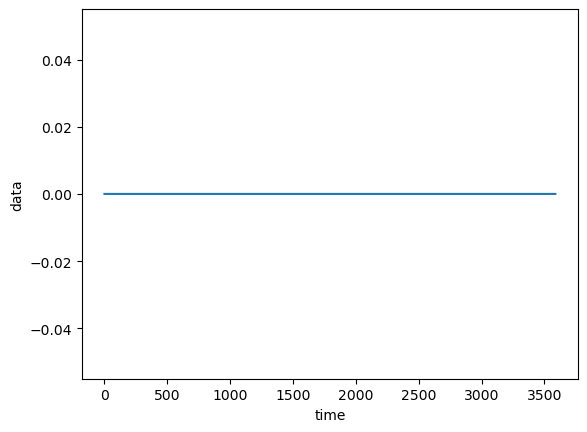

In [ ]:
path = r"C:\Users\Admin\Documents\Akseli\Code\ethograph\data\epilepsy\xx.nc"

from ethograph import TrialTree

dt = TrialTree.open(path)
dt.itrial(0).data.isel(variable=0).plot()

In [27]:

data

array([[ 0.03427913, -0.00629007, -0.00081863,  0.00233433],
       [ 0.02748151,  0.00535808,  0.28856805, -0.16937778],
       [-0.1909294 ,  0.26995438, -0.07998515,  0.06965058],
       ...,
       [-0.09595178, -0.03038446, -0.20613391,  0.09446711],
       [-0.06763683, -0.15279221,  0.07542843, -0.08179515],
       [-0.03732645,  0.00544678, -0.0470985 , -0.00109416]])

In [1]:
import numpy as np

n_samples = 107600*4
t = np.linspace(0, 10, n_samples)
data = np.column_stack([
    np.sin(2 * np.pi * 0.5 * t) + 0.1 * np.random.randn(n_samples),
    np.sin(2 * np.pi * 1.0 * t) + 0.1 * np.random.randn(n_samples),
    np.sin(2 * np.pi * 2.0 * t) + 0.1 * np.random.randn(n_samples),
    np.sin(2 * np.pi * 0.25 * t) + 0.1 * np.random.randn(n_samples),
])

from ethograph.utils.paths import get_project_root
np.save(get_project_root() / "data" / "epilepsy"  / "fake_channel_data.npy", data)

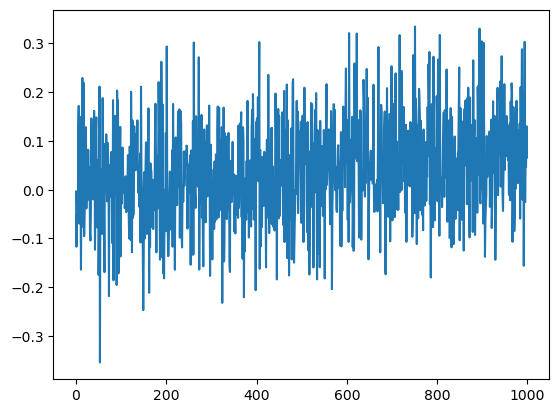

In [4]:
import matplotlib.pyplot as plt
plt.plot(data[:1000, 0])

In [16]:
"""
ezTrack-style motion detection for long videos.

Based on: Pennington ZT et al. (2019) "ezTrack: An open-source video analysis 
pipeline for the investigation of animal behavior." Scientific Reports.

Core algorithm: count pixels whose grayscale value changes above a threshold
between consecutive frames.
"""

from pathlib import Path

import cv2
import numpy as np


def compute_motion(
    video_path: str | Path,
    pixel_thresh: int = 10,
    downsample: int = 1,
    frame_skip: int = 0,
) -> tuple[np.ndarray, float]:
    """Compute frame-by-frame motion using ezTrack algorithm.
    
    Args:
        video_path: Path to video file.
        pixel_thresh: Minimum grayscale change to count as "moved" pixel.
        downsample: Spatial downsampling factor (2 = half resolution).
        frame_skip: Skip N frames between measurements (0 = all frames).
        
    Returns:
        Tuple of (motion_scores, fps).
        motion_scores: Fraction of pixels that changed per frame.
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    ret, frame = cap.read()
    if not ret:
        raise ValueError("Video contains no frames")
    
    if downsample > 1:
        frame = frame[::downsample, ::downsample]
    prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    scores = []
    frame_idx = 0
    
    while True:
        for _ in range(frame_skip):
            ret = cap.grab()
            if not ret:
                break
            frame_idx += 1
        
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        
        if downsample > 1:
            frame = frame[::downsample, ::downsample]
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        diff = cv2.absdiff(curr_gray, prev_gray)
        changed_pixels = np.sum(diff > pixel_thresh)
        total_pixels = diff.size
        scores.append(changed_pixels / total_pixels)
        
        prev_gray = curr_gray
    
    cap.release()
    return np.array(scores), fps


def detect_freezing(
    motion_scores: np.ndarray,
    fps: float,
    freeze_thresh: float = 0.01,
    min_freeze_duration: float = 0.5,
) -> np.ndarray:
    """Detect freezing episodes from motion scores.
    
    Args:
        motion_scores: Output from compute_motion().
        fps: Video frame rate.
        freeze_thresh: Motion below this = freezing.
        min_freeze_duration: Minimum freeze duration in seconds.
        
    Returns:
        Boolean array indicating freezing per frame.
    """
    is_frozen = motion_scores < freeze_thresh
    min_frames = int(min_freeze_duration * fps)
    
    # Remove short freezing bouts
    freeze_clean = is_frozen.copy()
    in_freeze = False
    freeze_start = 0
    
    for i, frozen in enumerate(is_frozen):
        if frozen and not in_freeze:
            freeze_start = i
            in_freeze = True
        elif not frozen and in_freeze:
            if i - freeze_start < min_frames:
                freeze_clean[freeze_start:i] = False
            in_freeze = False
    
    return freeze_clean



path = r"C:\Users\Admin\Documents\Akseli\Code\ethograph\data\copExpBP08\video.mp4"
scores, _ = compute_motion(path)

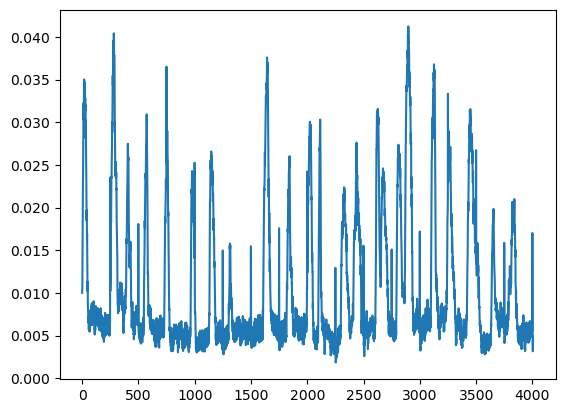

In [9]:
"""Calculate per-frame motion score from video using frame differencing."""


import numpy as np

import subprocess
import json

def bitrate_motion(video_path: str) -> tuple[np.ndarray, np.ndarray]:
    cmd = [
        "ffprobe", "-select_streams", "v", "-show_frames",
        "-show_entries", "frame=pts_time,pkt_size",
        "-of", "json", video_path
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    frames = json.loads(result.stdout)["frames"]
    
    timestamps = np.array([float(f["pts_time"]) for f in frames])
    sizes = np.array([int(f["pkt_size"]) for f in frames])
    return timestamps, sizes


path = r"C:\Users\Admin\Downloads\video.mp4"
idx, scores = bitrate_motion(path)

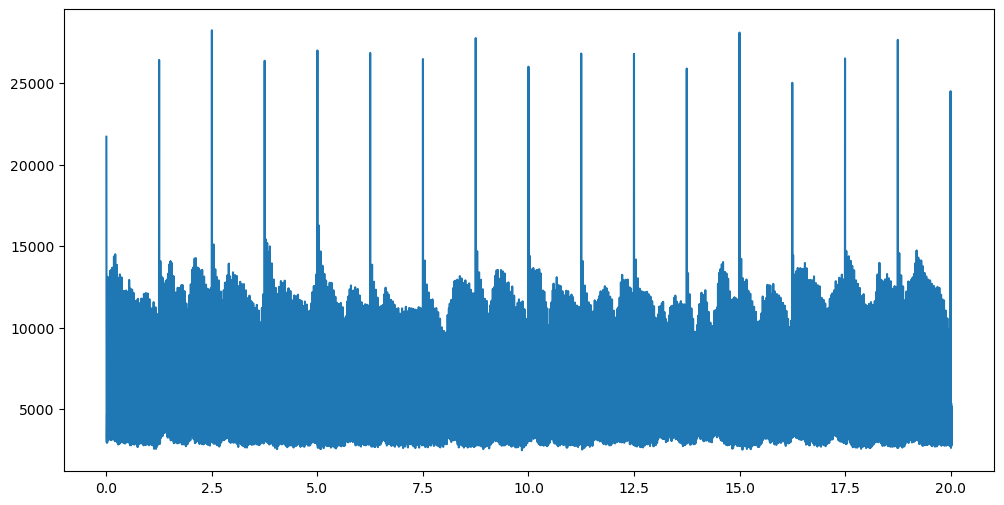

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.plot(idx, scores)

In [ ]:
import numpy as np
from numpy.typing import NDArray
from pathlib import Path
from queue import Queue
from concurrent.futures import ThreadPoolExecutor
from numba import njit, prange


@njit(parallel=True, fastmath=True, cache=True)
def _batch_diff_scores(batch: np.ndarray, count: int) -> np.ndarray:
    scores = np.empty(count - 1, dtype=np.float32)
    h, w = batch.shape[1], batch.shape[2]
    inv_size = np.float32(1.0 / (h * w))
    
    for i in prange(1, count):
        total = np.float32(0.0)
        for y in range(h):
            for x in range(w):
                total += abs(np.int16(batch[i, y, x]) - np.int16(batch[i - 1, y, x]))
        scores[i - 1] = total * inv_size
    
    return scores


def detect_changes_fast(
    video_path: Path,
    downsample: int = 8,
    batch_size: int = 2048,
    queue_size: int = 8,
) -> NDArray[np.float32]:
    import av

    container = av.open(str(video_path))
    stream = container.streams.video[0]
    stream.thread_type = "AUTO"
    
    h, w = stream.height // downsample, stream.width // downsample
    frame_queue: Queue[NDArray[np.uint8] | None] = Queue(maxsize=queue_size * batch_size)
    results: list[NDArray[np.float32]] = []
    
    def decode_worker():
        for frame in container.decode(video=0):
            frame_queue.put(frame.to_ndarray(format="gray8")[::downsample, ::downsample])
        frame_queue.put(None)
    
    def process_worker():
        batch = np.empty((batch_size + 1, h, w), dtype=np.uint8)
        idx = 0
        
        while True:
            gray = frame_queue.get()
            if gray is None:
                break
            
            batch[idx] = gray
            idx += 1
            
            if idx > batch_size:
                scores = _batch_diff_scores(batch, idx)
                results.append(scores)
                batch[0] = batch[idx - 1]
                idx = 1
        
        if idx > 1:
            results.append(_batch_diff_scores(batch, idx))
    
    with ThreadPoolExecutor(max_workers=2) as ex:
        decode_future = ex.submit(decode_worker)
        process_future = ex.submit(process_worker)
        decode_future.result()
        process_future.result()
    
    container.close()
    
    if results:
        return np.concatenate([[0.0], *results])
    return np.array([0.0], dtype=np.float32)


if __name__ == "__main__":
    import time
    
    path = Path(r"C:\Users\Admin\Downloads\video_looped_100x.mp4")
    
    # Warmup numba
    dummy = np.zeros((10, 64, 64), dtype=np.uint8)
    _batch_diff_scores(dummy, 10)
    
    t0 = time.perf_counter()
    scores = detect_changes_fast(path, downsample=8, batch_size=2048)
    elapsed = time.perf_counter() - t0
    
    print(f"Frames: {len(scores)}")
    print(f"Time: {elapsed:.2f}s")
    print(f"FPS: {len(scores) / elapsed:.0f}")

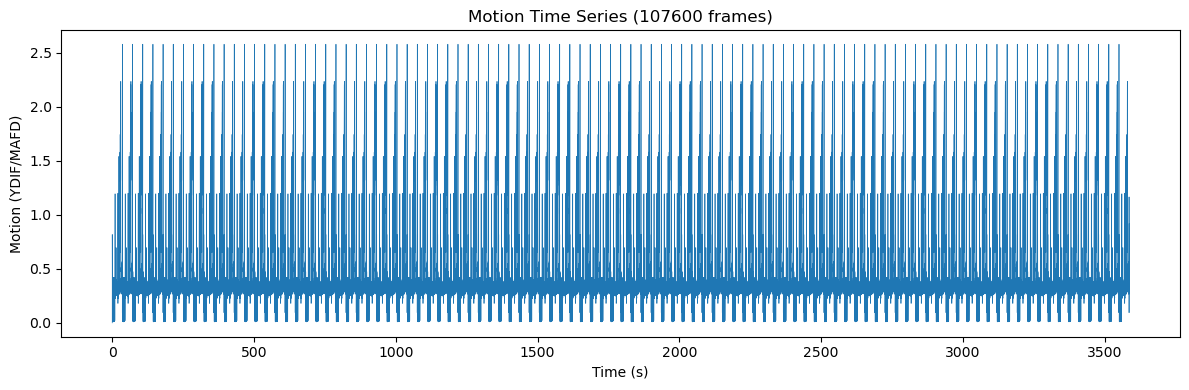

In [6]:
import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def parse_and_plot(filepath: Path, fps: float = 30.0):
    text = filepath.read_text()
    
    # Try YDIF first, fall back to MAFD
    pattern = r"lavfi\.signalstats\.YDIF=(\d+\.?\d*)"
    values = re.findall(pattern, text)
    
    if not values:
        pattern = r"lavfi\.scd\.mafd=(\d+\.?\d*)"
        values = re.findall(pattern, text)
    
    motion = np.array([float(v) for v in values], dtype=np.float32)
    time = np.arange(len(motion)) / fps
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time, motion, lw=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Motion (YDIF/MAFD)")
    ax.set_title(f"Motion Time Series ({len(motion)} frames)")
    plt.tight_layout()
    plt.show()
    
    return time, motion


# Usage
time, motion = parse_and_plot(Path(r"C:\Users\Admin\Downloads\motion.txt"), fps=30.0)

In [3]:
motion

array([0.      , 0.577966, 0.537066, ..., 0.20474 , 0.263813, 0.63979 ],
      dtype=float32)

(0.0, 200.0)

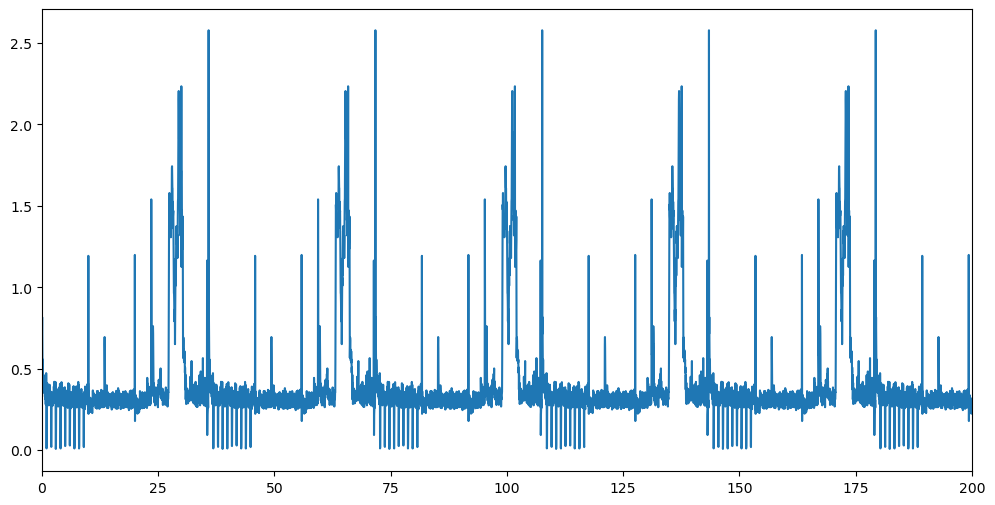

In [7]:

plt.figure(figsize=(12, 6))
plt.plot(time, motion)
plt.xlim(0, 200)

In [ ]:
# from pathlib import Path
# import shutil

# def delete_phy_folders(root_path: str, max_depth: int = 7, dry_run: bool = True) -> None:
#     root = Path(root_path)
#     phy_folders = []
    
#     def find_phy_folders(current_path: Path, current_depth: int) -> None:
#         if current_depth > max_depth:
#             return
        
#         for item in current_path.iterdir():
#             if item.is_dir():
#                 if item.name == ".phy":
#                     phy_folders.append(item)
#                 else:
#                     find_phy_folders(item, current_depth + 1)
    
#     find_phy_folders(root, 0)
    
#     if not phy_folders:
#         print("No .phy folders found")
#         return
    
#     print(f"Found {len(phy_folders)} .phy folder(s):")
#     for folder in phy_folders:
#         print(f"  {folder}")
    
#     if dry_run:
#         print("\nDry run mode - no folders deleted")
#         print("Set dry_run=False to actually delete")
#         return
    
#     for folder in phy_folders:
#         shutil.rmtree(folder)
#         print(f"Deleted: {folder}")

# if __name__ == "__main__":
#     path = r"F:\AK_data\rawdata"
#     delete_phy_folders(path, max_depth=7, dry_run=False)
#     # delete_phy_folders(path, max_depth=7, dry_run=False)

### Create Trial_data.nc

In [ ]:
%load_ext autoreload
%autoreload 2

from movement.io import load_poses
from movement.filtering import rolling_filter
from movement.kinematics import compute_pairwise_distances, compute_velocity, compute_acceleration, compute_forward_vector_angle, compute_time_derivative
from movement.utils.vector import compute_norm, cart2pol


from ethograph.utils.paths import get_session_path, extract_trial_info_from_filename
from ethograph import TrialTree, add_angle_rgb_to_ds,  add_changepoints_to_ds, set_media_attrs
from ethograph.features.mov_features import compute_distance_to_constant, Position3DCalibration
from ethograph.features.changepoints import find_troughs_binary, find_nearest_turning_points_binary
from ethograph.features.preprocessing import gaussian_smoothing
from scipy.io import loadmat
import glob
import os
import json
import warnings
import numpy as np
from pathlib import Path

warnings.filterwarnings(
    'ignore', 
    message='Confidence array was not provided.Setting to an array of NaNs',
    module='movement.validators.datasets'
)

user = "Alice"
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
json_file = os.path.join(desktop_path, "user_paths.json")
with open(json_file, "r") as file:
    paths = json.load(file)
raw_videos_folder = paths[user]["raw_videos_folder"]



fps = 200
freddy_good_s3d_feats = [ 326, 327, 292, 363, 219, 192, 260, 66, 332, 199,
       288, 763, 837, 182, 24, 218, 213, 21, 733, 242] 

ivy_good_s3d_feats = [192, 232, 330,  21, 115, 210, 102, 100, 114, 352, 107, 199, 813, 265,
                      4, 342, 460, 454, 21, 57] # last two are loher Cohen's D but specifically good for motif 18, 19

disp_xyz = [-10.23, -5.907, -1.395]
box1 = np.array([-7.08514973,  0.14055037,  0.58930513]) # front left
box2 = np.array([-6.97786264,  9.87752058,  0.96104736]) # back left
box3 = np.array([6.81007923, 9.72017014, 0.77115876]) # back right
box4 = np.array([ 6.77518696, -0.02424044,  0.60184316]) # front right


calibration = Position3DCalibration()
smoothing_params = {"sigma": 1.5, "axis": 0, "mode": "constant", "cval": np.nan}
clip_distance = 50 # cm (no distance feature exceeds this)

# raw!
behav_folders = [
                #  r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250527_01\behav",
                #  r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250527_02\behav",
                #  r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250528_01\behav",            
                #  r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250526_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250526_02\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250528_02\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250529_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250530_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250602_01\behav",
                
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250306_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250307_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250308_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250309_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250503_02\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250504_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250505_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250506_02\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250507_02\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250507_03\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250508_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250508_02\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250509_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250512_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250513_01\behav",
                
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250514_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250515_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250516_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250519_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250521_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250522_01\behav"       
                ]



for behav_folder in behav_folders:
    print(f"Processing folder: {behav_folder}")

    dlc_3d_paths = np.sort(glob.glob(os.path.join(behav_folder, "dlc", "*_3D.csv")))


    ds_list = []
    for dlc_3d_path in dlc_3d_paths:
        ds = load_poses.from_dlc_file(dlc_3d_path, fps=fps)
        
        session_date, trial_num, bird = extract_trial_info_from_filename(dlc_3d_path)
        ds = ds.assign_coords(individuals=[bird])
        ds.attrs["trial"] = trial_num # can be number or string, has to be unique per session
        ds.attrs["session"] = f"{session_date}_{str(Path(behav_folder).parent)[-2:]}"  # e.g. "20250527_sub-03_id-Freddy"
        ds.attrs["bird"] = bird
        
        
        ## removed trials
        if session_date
        
        
        if bird == "Freddy":
            good_s3d_feats = freddy_good_s3d_feats
        elif bird == "Ivy":
            good_s3d_feats = ivy_good_s3d_feats
        else:
            raise ValueError(f"Unknown bird ID: {bird}, add S3D depedency.")


        base_name = os.path.basename(dlc_3d_path)
        dlc_suffix = "DLC_resnet50_Felix_cross_SessionsAug1shuffle1_200000_filtered"
        
        ds = set_media_attrs(
            ds,
            cameras=[
                base_name.replace("_DLC_3D.csv", "-cam-1.mp4"),
                base_name.replace("_DLC_3D.csv", "-cam-2.mp4"),
            ],
            # tracking=[
            #     base_name.replace("_DLC_3D.csv", f"-cam-1{dlc_suffix}.csv"),
            #     base_name.replace("_DLC_3D.csv", f"-cam-2{dlc_suffix}.csv"),
            # ],
            # tracking_prefix="dlc",
        )
        

   
        ds = calibration.transform(ds) 
        ds["position"] = gaussian_smoothing(ds.position, **smoothing_params)
        

    



        
        ds["velocity"] = compute_velocity(ds.position.sel(keypoints=['stickTip', 'beakTip'])).clip(min=-150, max=150)
        ds["speed"] = compute_norm(ds.velocity.sel(keypoints=['stickTip', 'beakTip']))
        
        
        smoothing_params_doubled = smoothing_params.copy()
        smoothing_params_doubled["sigma"] *= 2
        position_very_smooth = gaussian_smoothing(ds.position, **smoothing_params_doubled)
        position_very_smooth = gaussian_smoothing(ds.position, **smoothing_params_doubled)
        ds["acceleration"] = compute_acceleration(position_very_smooth.sel(keypoints=['stickTip', 'beakTip'])).clip(min=-1500, max=1500)
        
        

        # Distances
        ds["pellet_beakTip_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"pellet": "beakTip"}).clip(0, clip_distance)
        ds["pellet_stickTip_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"pellet": "stickTip"}).clip(0, clip_distance)
        ds["disp_beakTip_dist"] = compute_distance_to_constant(ds.position, reference_point=disp_xyz, keypoint="beakTip").clip(0, clip_distance)
        ds["disp_stickTip_dist"] = compute_distance_to_constant(ds.position, reference_point=disp_xyz, keypoint="stickTip").clip(0, clip_distance)
        
        ds["sticktip_cornerLFront_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"stickTip": "box1"}).clip(0, clip_distance)
        ds["sticktip_cornerLBack_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"stickTip": "box2"}).clip(0, clip_distance)
        ds["sticktip_cornerRBack_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"stickTip": "box3"}).clip(0, clip_distance)
        ds["sticktip_cornerRFront_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"stickTip": "box4"}).clip(0, clip_distance)

        ds["beakTip_cornerLFront_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"beakTip": "box1"}).clip(0, clip_distance)
        ds["beakTip_cornerLBack_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"beakTip": "box2"}).clip(0, clip_distance)
        ds["beakTip_cornerRBack_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"beakTip": "box3"}).clip(0, clip_distance)
        ds["beakTip_cornerRFront_dist"] = compute_pairwise_distances(ds.position, "keypoints", {"beakTip": "box4"}).clip(0, clip_distance)

        

        
        # Only keep subset of keypoints
        ds = ds.sel(keypoints=["beakTip", "stickTip", "pellet"])


        s3d_file = base_name.replace("_DLC_3D.csv", "-cam-1_s3d.npy")
        s3d_path = os.path.join(behav_folder, "s3d", s3d_file)
        s3d_data = np.load(s3d_path)
        
        ds["s3d"] = (("time", "s3d_dims"), s3d_data[:, good_s3d_feats])


        for var in ds.data_vars:
            ds[var].attrs["type"] = "features"
            
        
        ds = add_changepoints_to_ds(
            ds=ds, 
            target_feature="speed",
            changepoint_name="troughs", 
            changepoint_func=find_troughs_binary, 
            prominence=0.5, 
            distance=2
        )
        
        ds = add_changepoints_to_ds(
            ds=ds,
            target_feature="speed",
            changepoint_name="turning_points",
            changepoint_func=find_nearest_turning_points_binary,
            threshold=1.0,
            max_value=50,
            prominence=5,
            width=2
        )
        
        ds = add_angle_rgb_to_ds(ds, smoothing_params=smoothing_params)
        
        
        ds["labels"] = (("time", "individuals"), np.zeros((len(ds.coords["time"]), len(ds.coords["individuals"]))))
        
        
        
        # From matlab
        deriv_behav_folder = behav_folder.replace("rawdata", "derivatives")
        AllTrialsPath = os.path.join(deriv_behav_folder, "Trial_data.mat")
        
        mat_data = loadmat(AllTrialsPath, squeeze_me=True, struct_as_record=False)
        AllTrials = mat_data['AllTrials']
        
        for i, trial in enumerate(AllTrials):
            if trial.trial_num == trial_num:
                ds.attrs["poscat"] = trial.info.poscat
                ds.attrs["num_pellets"] = trial.info.num_pellets
              
                

                event_data = np.zeros(4)  
                
                disp_out_in = trial.info.stick_in_out_disp
                disp_out = int(disp_out_in[0]) -1
                
                for j, val in enumerate([0, 1]):
                    try:
                        event_data[j] = int(disp_out_in[val]) - 1
                    except Exception:
                        event_data[j] = np.nan
                for j, idx in enumerate([0, 1], start=2):
                    try:
                        event_data[j] = int(trial.info.first_in_last_out[idx-2]) - 1
                    except Exception:
                        event_data[j] = np.nan

                ds["boundary_events"] = ("events", event_data)
                ds.assign_coords(events=("events", ["disp_out", "disp_in", "box_in", "box_out"]))
    

        ds_list.append(ds)


    deriv_behav_folder = behav_folder.replace("rawdata", "derivatives")
    dt = TrialTree.from_datasets(ds_list)
    dt.to_netcdf(os.path.join(deriv_behav_folder, "Trial_data.nc"))

In [ ]:
{'uncorrected': {'Acc': 98.66693107703155, 'Edit': np.float64(76.94422064537693), 'TP': 1853.0, 'FP': 0.0, 'FN': 40.0, 'Frame_F1': 98.56583547934594, 'F1@50': np.float64(97.73095623987035), 'F1@75': np.float64(95.00831946755409), 'F1@90': np.float64(89.49211908931699), 'classwise_results': {1: {'f1s': array([98.71794872, 96.05263158, 92.5170068 ]), 'tp': array([77., 73., 68.]), 'fp': array([2., 2., 2.]), 'fn': array([0., 4., 9.])}, 2: {'f1s': array([100.        ,  97.95918367,  92.85714286]), 'tp': array([75., 72., 65.]), 'fp': array([0., 0., 0.]), 'fn': array([ 0.,  3., 10.])}, 3: {'f1s': array([80., 80., 80.]), 'tp': array([4., 4., 4.]), 'fp': array([0., 0., 0.]), 'fn': array([2., 2., 2.])}, 4: {'f1s': array([98.96907216, 98.96907216, 95.74468085]), 'tp': array([48., 48., 45.]), 'fp': array([1., 1., 1.]), 'fn': array([0., 0., 3.])}, 5: {'f1s': array([100.       , 100.       ,  98.7654321]), 'tp': array([41., 41., 40.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 0., 1.])}, 6: {'f1s': array([100.       , 100.       ,  91.4893617]), 'tp': array([51., 51., 43.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 0., 8.])}, 7: {'f1s': array([93.61702128, 91.30434783, 85.49618321]), 'tp': array([66., 63., 56.]), 'fp': array([8., 8., 8.]), 'fn': array([ 1.,  4., 11.])}, 8: {'f1s': array([100.        ,  98.63013699,  92.75362319]), 'tp': array([74., 72., 64.]), 'fp': array([0., 0., 0.]), 'fn': array([ 0.,  2., 10.])}, 9: {'f1s': array([94.        , 90.15544041, 79.54545455]), 'tp': array([94., 87., 70.]), 'fp': array([4., 4., 4.]), 'fn': array([ 8., 15., 32.])}, 10: {'f1s': array([98.68421053, 98.01324503, 91.54929577]), 'tp': array([75., 74., 65.]), 'fp': array([1., 1., 1.]), 'fn': array([ 1.,  2., 11.])}, 11: {'f1s': array([99.2481203 , 98.48484848, 92.8       ]), 'tp': array([66., 65., 58.]), 'fp': array([1., 1., 1.]), 'fn': array([0., 1., 8.])}, 12: {'f1s': array([97.10144928, 95.58823529, 87.3015873 ]), 'tp': array([67., 65., 55.]), 'fp': array([4., 4., 4.]), 'fn': array([ 0.,  2., 12.])}, 13: {'f1s': array([99.44134078, 95.95375723, 86.79245283]), 'tp': array([89., 83., 69.]), 'fp': array([0., 0., 0.]), 'fn': array([ 1.,  7., 21.])}, 14: {'f1s': array([91.66666667, 90.14084507, 88.57142857]), 'tp': array([33., 32., 31.]), 'fp': array([6., 6., 6.]), 'fn': array([0., 1., 2.])}, 15: {'f1s': array([99.31972789, 97.93103448, 89.55223881]), 'tp': array([73., 71., 60.]), 'fp': array([0., 0., 0.]), 'fn': array([ 1.,  3., 14.])}, 16: {'f1s': array([99.00990099, 94.84536082, 82.75862069]), 'tp': array([50., 46., 36.]), 'fp': array([0., 0., 0.]), 'fn': array([ 1.,  5., 15.])}, 17: {'f1s': array([95.57522124, 91.74311927, 89.71962617]), 'tp': array([54., 50., 48.]), 'fp': array([4., 4., 4.]), 'fn': array([1., 5., 7.])}, 20: {'f1s': array([80.        , 80.        , 73.68421053]), 'tp': array([8., 8., 7.]), 'fp': array([4., 4., 4.]), 'fn': array([0., 0., 1.])}}, 'all_IoUs': array([1., 1., 1., ..., 1., 1., 1.], shape=(4203,)), 'start_deltas': array([], dtype=float64), 'end_deltas': array([], dtype=float64)}, 'corrected': {'Acc': 98.79619836653153, 'Edit': np.float64(95.0401083660433), 'TP': 1847.0, 'FP': 0.0, 'FN': 46.0, 'Frame_F1': 98.56949159668282, 'F1@50': np.float64(98.41695733834183), 'F1@75': np.float64(96.81112019623875), 'F1@90': np.float64(92.56526674233825), 'classwise_results': {1: {'f1s': array([100.        ,  96.6442953 ,  93.05555556]), 'tp': array([77., 72., 67.]), 'fp': array([0., 0., 0.]), 'fn': array([ 0.,  5., 10.])}, 2: {'f1s': array([100.        ,  97.95918367,  94.36619718]), 'tp': array([75., 72., 67.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 3., 8.])}, 3: {'f1s': array([80.        , 80.        , 66.66666667]), 'tp': array([4., 4., 3.]), 'fp': array([0., 0., 0.]), 'fn': array([2., 2., 3.])}, 4: {'f1s': array([98.96907216, 98.96907216, 96.84210526]), 'tp': array([48., 48., 46.]), 'fp': array([1., 1., 1.]), 'fn': array([0., 0., 2.])}, 5: {'f1s': array([100. , 100. ,  97.5]), 'tp': array([41., 41., 39.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 0., 2.])}, 6: {'f1s': array([100.        ,  99.00990099,  95.91836735]), 'tp': array([51., 50., 47.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 1., 4.])}, 7: {'f1s': array([98.50746269, 96.18320611, 90.32258065]), 'tp': array([66., 63., 56.]), 'fp': array([1., 1., 1.]), 'fn': array([ 1.,  4., 11.])}, 8: {'f1s': array([100.       , 100.       ,  96.5034965]), 'tp': array([74., 74., 69.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 0., 5.])}, 9: {'f1s': array([95.95959596, 94.35897436, 86.81318681]), 'tp': array([95., 92., 79.]), 'fp': array([1., 1., 1.]), 'fn': array([ 7., 10., 23.])}, 10: {'f1s': array([99.33774834, 99.33774834, 92.95774648]), 'tp': array([75., 75., 66.]), 'fp': array([0., 0., 0.]), 'fn': array([ 1.,  1., 10.])}, 11: {'f1s': array([100.        ,  99.23664122,  95.23809524]), 'tp': array([66., 65., 60.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 1., 6.])}, 12: {'f1s': array([100.        ,  98.48484848,  91.05691057]), 'tp': array([67., 65., 56.]), 'fp': array([0., 0., 0.]), 'fn': array([ 0.,  2., 11.])}, 13: {'f1s': array([99.44134078, 96.55172414, 86.79245283]), 'tp': array([89., 84., 69.]), 'fp': array([0., 0., 0.]), 'fn': array([ 1.,  6., 21.])}, 14: {'f1s': array([100.   , 100.   ,  96.875]), 'tp': array([33., 33., 31.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 0., 2.])}, 15: {'f1s': array([100.        ,  99.31972789,  91.17647059]), 'tp': array([74., 73., 62.]), 'fp': array([0., 0., 0.]), 'fn': array([ 0.,  1., 12.])}, 16: {'f1s': array([99.00990099, 96.96969697, 86.66666667]), 'tp': array([50., 48., 39.]), 'fp': array([0., 0., 0.]), 'fn': array([ 1.,  3., 12.])}, 17: {'f1s': array([98.18181818, 95.3271028 , 94.33962264]), 'tp': array([54., 51., 50.]), 'fp': array([1., 1., 1.]), 'fn': array([1., 4., 5.])}, 20: {'f1s': array([100.        , 100.        ,  93.33333333]), 'tp': array([8., 8., 7.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 0., 1.])}}, 'all_IoUs': array([1., 1., 1., ..., 1., 1., 1.], shape=(3168,)), 'start_deltas': array([], dtype=float64), 'end_deltas': array([], dtype=float64)}}

In [4]:
path = r"D:\Akseli\Code\ethograph\result\Ivy_train_20260128_171450\split_1\test_results_epoch100.npy"

import numpy as np
data = np.load(path, allow_pickle=True)
print(data)

{'uncorrected': {'Acc': 98.66693107703155, 'Edit': np.float64(76.94422064537693), 'TP': 1853.0, 'FP': 0.0, 'FN': 40.0, 'Frame_F1': 98.56583547934594, 'F1@50': np.float64(97.73095623987035), 'F1@75': np.float64(95.00831946755409), 'F1@90': np.float64(89.49211908931699), 'classwise_results': {1: {'f1s': array([98.71794872, 96.05263158, 92.5170068 ]), 'tp': array([77., 73., 68.]), 'fp': array([2., 2., 2.]), 'fn': array([0., 4., 9.])}, 2: {'f1s': array([100.        ,  97.95918367,  92.85714286]), 'tp': array([75., 72., 65.]), 'fp': array([0., 0., 0.]), 'fn': array([ 0.,  3., 10.])}, 3: {'f1s': array([80., 80., 80.]), 'tp': array([4., 4., 4.]), 'fp': array([0., 0., 0.]), 'fn': array([2., 2., 2.])}, 4: {'f1s': array([98.96907216, 98.96907216, 95.74468085]), 'tp': array([48., 48., 45.]), 'fp': array([1., 1., 1.]), 'fn': array([0., 0., 3.])}, 5: {'f1s': array([100.       , 100.       ,  98.7654321]), 'tp': array([41., 41., 40.]), 'fp': array([0., 0., 0.]), 'fn': array([0., 0., 1.])}, 6: {'f1s'

## Modify AllTrials.nc

In [ ]:
%load_ext autoreload
%autoreload 2


from scipy.io import loadmat
import glob
import os
import json
import warnings
import numpy as np
from pathlib import Path
import xarray as xr
from ethograph_matlab import update_dt_with_matlab_pulse_onsets
from ethograph.features.mov_features import compute_aux_velocity_and_speed
from ethograph.features.preprocessing import resample_to_frames, clip_by_percentiles, downsample_with_antialiasing
from ethograph import TrialTree


user = "Alice"
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
json_file = os.path.join(desktop_path, "user_paths.json")
with open(json_file, "r") as file:
    paths = json.load(file)
raw_videos_folder = paths[user]["raw_videos_folder"]


fps = 200

# raw!
behav_folders = [
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250527_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250527_02\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250528_01\behav",            
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250526_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250526_02\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250528_02\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250529_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250530_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-03_id-Freddy\ses-000_date-20250602_01\behav",
                
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250306_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250307_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250308_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250309_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250503_02\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250504_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250505_01\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250506_02\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250507_02\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250507_03\behav",
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250508_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250508_02\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250509_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250512_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250513_01\behav",
                
                # r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250514_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250515_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250516_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250519_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250521_01\behav",
                r"D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250522_01\behav"       
                ]

accel_path = r"D:\Alice\AK_data\rawdata\accelerometer_copied"

def read_intan_auxiliary(filepath: str, n_channels: int = 3) -> np.ndarray:
    """Read Intan auxiliary.dat file. Returns array in volts."""
    raw = np.fromfile(filepath, dtype=np.uint16)
    return raw.reshape(-1, n_channels) * 0.0000374

def read_intan_timestamps(filepath: str, sample_rate: float = 30000.0) -> np.ndarray:
    raw = np.fromfile(filepath, dtype=np.int32)
    return raw / sample_rate

for behav_folder in behav_folders:
    print(f"Processing folder: {behav_folder}")
    
    deriv_behav_folder = behav_folder.replace("rawdata", "derivatives")
    nc_path = Path(deriv_behav_folder) / "Trial_data.nc"
    
    dt = TrialTree.open(nc_path)

    AllTrialsPath = os.path.join(deriv_behav_folder, "Trial_data.mat")
    AllTrialsPath = AllTrialsPath.replace(r"D:\Alice\AK_data", r"E:\AK_data") # AllTrils.mat where pulse onsets are (after merge of left and right PC)

    dt = update_dt_with_matlab_pulse_onsets(nc_path, AllTrialsPath)


    
    session = dt.itrial(0).session
    session = session.replace("-", "")
    bird = dt.itrial(0).bird
    
    dat_path = Path(accel_path) / bird / session / "auxiliary.dat"
    time_path = Path(accel_path) / bird / session / "time.dat"
    
    aux = read_intan_auxiliary(dat_path)
    time = read_intan_timestamps(time_path)
    
    for trial in dt.trials:
        time_frames = dt.trial(trial).time.values
        
        
        
        
        pulse_onsets = dt.trial(trial).pulse_onsets.values
    

    
        trial_sample_indices = np.arange(pulse_onsets[0], pulse_onsets[-1] + 150)
        
        aux_trial = aux[trial_sample_indices, :]
        time_trial = time[trial_sample_indices] - time[trial_sample_indices[0]]

        aux_accel, aux_velocity, aux_speed = compute_aux_velocity_and_speed(
            aux_trial, time_trial, 
            mov_mean_window1=6001, 
            mov_mean_window2=15001
        )

        ds = dt[f"trial_{trial}"].to_dataset().copy()        

        ds['pulse_onsets'] = xr.DataArray(
            pulse_onsets,
            dims=['time',],
            coords={'time': time_frames}
        )

        # As model feature
        time_frames = dt.trial(trial).time.values
        aux_acceleration = resample_to_frames(aux_accel, time_trial, time_frames)
        aux_acceleration = clip_by_percentiles(aux_acceleration, (5, 95))
        aux_velocity = resample_to_frames(aux_velocity, time_trial, time_frames)
        aux_speed = resample_to_frames(aux_speed, time_trial, time_frames)        
        
        ds['aux_acceleration'] = xr.DataArray(
            aux_acceleration,
            dims=['time', 'space'],
            coords={'time': time_frames, 'space': ['x', 'y', 'z']}
        )
        ds['aux_velocity'] = xr.DataArray(
            aux_velocity,
            dims=['time', 'space'],
            coords={'time': time_frames, 'space': ['x', 'y', 'z']}
        )
        ds['aux_speed'] = xr.DataArray(
            aux_speed,
            dims=['time'],
            coords={'time': time_frames}
        )
        for feat in ["aux_acceleration", "aux_velocity", "aux_speed"]:
            ds[feat].attrs["type"] = "features"
            
            
        
        # # Loaded the data below in GUI, and aux_velocity_1000Hz and aux_velocity_200Hz basically look the same (just smoother)
        # # -> therefore not needed. aux_acceleration_1000Hz picks up high frequency vibration, but not of interest for us. 
        # downsample_factor = 30  # 30000 / 1000
        # aux_accel_1000Hz = downsample_with_antialiasing(aux_accel, downsample_factor)
        # aux_velocity_1000Hz = downsample_with_antialiasing(aux_velocity, downsample_factor)
        # aux_speed_1000Hz = downsample_with_antialiasing(aux_speed, downsample_factor)
        # time_downsampled = time_trial[::30][:len(aux_accel_1000Hz)]
        
        # ds['aux_acceleration_1000Hz'] = xr.DataArray(
        #     aux_accel_1000Hz,
        #     dims=['time_1000Hz', 'space'],
        #     coords={'time_1000Hz': time_downsampled, 'space': ['x', 'y', 'z']}
        # )
        # ds['aux_velocity_1000Hz'] = xr.DataArray(
        #     aux_velocity_1000Hz,
        #     dims=['time_1000Hz', 'space'],
        #     coords={'time_1000Hz': time_downsampled, 'space': ['x', 'y', 'z']}
        # )
        # ds['aux_speed_1000Hz'] = xr.DataArray(
        #     aux_speed_1000Hz,
        #     dims=['time_1000Hz'],
        #     coords={'time_1000Hz': time_downsampled}
        # )
        # for feat in ["aux_acceleration_1000Hz", "aux_velocity_1000Hz", "aux_speed_1000Hz"]:
        #     ds[feat].attrs["type"] = "fake_features"
        
        
        dt[f"trial_{trial}"] = ds
    
    dt.save()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250508_02\behav
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250509_01\behav
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250512_01\behav
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250513_01\behav
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250515_01\behav
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250516_01\behav
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250519_01\behav
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250521_01\behav
Processing folder: D:\Alice\AK_data\rawdata\sub-01_id-Ivy\ses-000_date-20250522_01\behav


In [ ]:
def my_function(required_arg, **kwargs):
    color = kwargs.get('color', 'red')
    size = kwargs.get('size', 10)
    verbose = kwargs.get('verbose', False)
    
    def do_maths(size):
        return size * 2
    
    print(do_maths(size))
    print(f"{required_arg=}, {color=}, {size=}, {verbose=}")

my_function("hello")
my_function("hello", color="blue", size=20)
my_function("hello", **{"color": "green", "verbose": True})

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [ ]:
from ethograph import TrialTree
from pathlib import Path

label_folders = [r"D:\Akseli\Ivy_label\ses-000_date-20250306_01\behav\labels\Trial_data_labels_20260126_155846.nc",
                 r"D:\Akseli\Ivy_label\ses-000_date-20250309_01\behav\labels\Trial_data_labels_20260126_154612.nc",
                 r"D:\Akseli\Ivy_label\ses-000_date-20250503_02\behav\labels\Trial_data_labels_20260127_102158.nc",
                 r"D:\Akseli\Ivy_label\ses-000_date-20250514_01\behav\labels\Trial_data_labels_20260128_103350.nc"
]


for behav_folder, label_path in zip(behav_folders, label_folders):
    
    deriv_behav_folder = behav_folder.replace("rawdata", "derivatives")
    
    
    path = Path(deriv_behav_folder) / "Trial_data.nc"

    dt = TrialTree.open(path)
    label_dt = TrialTree.open(label_path)
    
    updated_dt = dt.overwrite_with_labels(label_dt)
    
    temp_path = Path(deriv_behav_folder) / "Trial_data_done.nc"
    updated_dt.to_netcdf(temp_path, mode='w')

In [12]:
dt.itrial(0).s3d

<xarray.DataArray 's3d' (time: 2080, s3d_dims: 1024)> Size: 17MB
[2129920 values with dtype=float64]
Coordinates:
  * time     (time) float64 17kB 0.0 0.005 0.01 0.015 ... 10.38 10.39 10.39
Dimensions without coordinates: s3d_dims
Attributes:
    type:     features

In [ ]:
path = r"C:/Users/aksel/Documents/Code/EthoGraph/data/Night_of_the_Living_Dead/MovieString.nc"

from ethograph import TrialTree
dt = TrialTree.open(path)
ds = dt.itrial(0)